In [1]:
from keras.models import Model
import numpy as np
from keras.layers import Input, Dense, Reshape, Flatten, Activation
from keras.layers import Embedding, Lambda, Concatenate, Add
from tensorflow.keras.layers import Conv3DTranspose,Conv2DTranspose, Conv3D,Conv2D,GlobalAvgPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.layers import LeakyReLU
import keras.backend as K
import os
from keras.layers import GlobalAvgPool3D, Multiply
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import UpSampling3D, Cropping3D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import numpy as np
import re

In [2]:
def dense_layer(inp, f, act='relu', bn=True):
    initializer = act if act is not None else ''
    initializer = 'he_uniform' if initializer.find('relu') != -1 else 'glorot_uniform'
    out = Dense(f, use_bias=False, kernel_initializer=initializer)(inp)
    if bn: out = BatchNormalization()(out)
    
    if act == 'lrelu':
        out = LeakyReLU(alpha=0.2)(out)
    elif act is not None:
        out = Activation(act)(out)
    
    return out

def conv_layer(inp, f, k=4, s=2, p='same', act='relu', bn=True, transpose=False,
               se=False, se_ratio=16):
    initializer = act if act is not None else ''
    initializer = 'he_uniform' if initializer.find('relu') != -1 else 'glorot_uniform'
    fun = Conv3DTranspose if transpose else Conv3D
    out = fun(f, k, strides=s, padding=p, use_bias=False, kernel_initializer=initializer)(inp)
    if bn: out = BatchNormalization()(out)
    
    if act == 'lrelu':
        out = LeakyReLU(alpha=0.2)(out)
    elif act is not None:
        out = Activation(act)(out)

    # squeeze and excite
    if se:
        out_se = GlobalAvgPool3D()(out)
        r = f // se_ratio if (f // se_ratio) > 0 else 1
        out_se = Reshape((1, 1, f))(out_se)
        out_se = Dense(r, use_bias=False, kernel_initializer='he_uniform',
                       activation='relu')(out_se)
        out_se = Dense(f, use_bias=False, activation='sigmoid')(out_se)
        out = Multiply()([out, out_se])
    
    return out

In [3]:
def make_discriminator(dict_size, model_type, se=False):
    # Inputs
    labels = Input(shape=(1,))
    voxels_inp = Input(shape=(32, 32, 32))
    voxels = Lambda(lambda x: K.expand_dims(x))(voxels_inp)

    # Label embedding
    embs = Embedding(dict_size, 64, input_length=1)(labels)
    embs = Flatten()(embs)
    embs = dense_layer(embs, 1024, act='lrelu', bn=False)

    # Convolutional layers for voxels
    out_voxels = conv_layer(voxels, 32, 5, 1, act='lrelu', bn=False, se=se)
    out_voxels = conv_layer(out_voxels, 32, act='lrelu', bn=False, se=se)
    out_voxels = conv_layer(out_voxels, 64, act='lrelu', bn=False, se=se)
    out_voxels = conv_layer(out_voxels, 128, act='lrelu', bn=False, se=se)
    out_voxels = conv_layer(out_voxels, 256, act='lrelu', bn=False, se=se)
    out_voxels = Flatten()(out_voxels)

    # Dense layers for images
    out_images = Flatten()(voxels)
    out_images = dense_layer(out_images, 1024, act='lrelu', bn=False)

    # Concatenate the output of both branches
    out = Concatenate()([out_voxels, out_images, embs])

    # Continue with dense layers
    out = dense_layer(out, 1024, act='lrelu', bn=False)
    out = dense_layer(out, 512, act='lrelu', bn=False)
    out = dense_layer(out, 1, act=None, bn=False)

    return Model([voxels_inp, labels], out)

In [4]:
def make_generator(dict_size):
    # inputs
    labels = Input(shape=(1,))
    img_inp = Input(shape=(128, 128, 1))

    print(f"Input labels shape: {labels.shape}")
    print(f"Input image shape: {img_inp.shape}")

    # label embedding
    embs = Embedding(dict_size, 32, input_length=1)(labels)
    embs = Flatten()(embs)
    embs = dense_layer(embs, 512)

    # conv layers
    img_conv = Conv2D(16, kernel_size=5, strides=1, padding="same", activation="relu")(Lambda(lambda x: K.expand_dims(x))(img_inp))
    img_conv = Conv2D(16, kernel_size=3, strides=1, padding="same", activation="relu")(img_conv)
    img_conv = Conv2D(32, kernel_size=3, strides=1, padding="same", activation="relu")(img_conv)

    mix = Flatten()(img_conv)
    mix = dense_layer(mix, 512)
    mix = dense_layer(mix, 2 * 2 * 2 * 128)
    mix = Lambda(lambda x: K.reshape(x, (-1, 2, 2, 2, 128)))(mix)

    print(f"Intermediate mix shape: {mix.shape}")

    out = conv_layer(mix, 128, k=(3, 3, 3), s=(2, 2, 2), transpose=True, p="same", act="relu")
    out = conv_layer(out, 64, k=(3, 3, 3), s=(2, 2, 2), transpose=True, p="same", act="relu")
    out = conv_layer(out, 32, k=(3, 3, 3), s=(2, 2, 2), transpose=True, p="same", act="relu")
    out = conv_layer(out, 16, k=(3, 3, 3), s=(2, 2, 2), transpose=True, p="same", act="relu")

    out = Conv3D(1, kernel_size=(3, 3, 3), padding="same", activation="tanh")(out)

    print(f"Output shape: {out.shape}")

    # Return the model
    return Model([img_inp, labels], out)


In [5]:
def make_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(128, 128, 1))
    label = Input(shape=(1,))
    generated_image = generator([gan_input, label])
    gan_output = discriminator([generated_image, label])
    gan = Model([gan_input, label], gan_output)
    return gan

In [6]:
dict_size = 2 
discriminator = make_discriminator(dict_size, 'voxels-v')
discriminator.summary()
discriminator.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 32)]         0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32, 32, 32, 1)        0         ['input_2[0][0]']             
                                                                                                  
 conv3d (Conv3D)             (None, 32, 32, 32, 32)       4000      ['lambda[0][0]']              
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32, 32)       0         ['conv3d[0][0]']              
                                                                                             

In [7]:
generator = make_generator(dict_size)
gan = make_gan(generator, discriminator)
generator.summary()

Input labels shape: (None, 1)
Input image shape: (None, 128, 128, 1)
Intermediate mix shape: (None, 2, 2, 2, 128)

Output shape: (None, 32, 32, 32, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 128, 128, 1, 1)       0         ['input_4[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 1, 16)      416       ['lambda_1[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128,

In [8]:
def train_gan(generator, discriminator, gan, image_data, voxel_data, epochs=2, batch_size=64,save_path='gan_model.h5'):
    dict_size = len(np.unique(voxel_data))  # Assuming dict_size is the number of unique classes in voxel data

    # Normalizar e redimensionar imágenes fuera del bucle
    image_data = image_data / 255.0
    

    for epoch in range(epochs):
        d_loss = [0, 0]  # Inicializa d_loss como una lista antes del bucle

        for _ in range(len(image_data) // batch_size):
            # Train Discriminator
            idx = np.random.randint(0, min(image_data.shape[0], voxel_data.shape[0]), batch_size)
            real_images = image_data[idx]
            real_voxels = voxel_data[idx]
            labels_batch = np.random.randint(0, dict_size, batch_size).reshape(-1, 1)


            fake_voxels = generator.predict([real_images, labels_batch])

            d_loss_real = discriminator.train_on_batch([real_voxels, labels_batch], np.ones((batch_size, 1)))

            fake_labels = np.random.randint(0, dict_size, batch_size).reshape(-1, 1)
            d_loss_fake = discriminator.train_on_batch([fake_voxels, labels_batch], np.zeros((batch_size, 1)))

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            fake_voxels = generator.predict([real_images, fake_labels])
            #print("Real Voxels Shape:", real_voxels.shape)
            #print("Real Images Shape:", real_images.shape)
            #print("Discriminator Input Shape:", discriminator.input_shape)


            labels_batch = np.random.randint(0, dict_size, batch_size).reshape(-1, 1)
            d_loss_real = discriminator.train_on_batch([real_voxels, labels_batch], np.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch([fake_voxels, fake_labels], np.zeros((batch_size, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            fake_labels = np.random.randint(0, dict_size, batch_size).reshape(-1, 1)
            valid_labels = np.ones((batch_size, 1))
            g_loss = gan.train_on_batch([real_images, fake_labels], valid_labels)

            # Imprimir resultados del lote
            print(f"Batch - Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

        # Imprimir resultados al final de cada época
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        #print(f'Real Images Shape: {real_images.shape}')
        #print(f'Generated Voxels Shape: {fake_voxels.shape}')
        #print(f'Discriminator Input Shape: {discriminator.input_shape}')
        gan.save(save_path)





In [9]:
X_train = np.load('./X_train.npy')
y_train = np.load('./y_train.npy')

# Normalizar imágenes en el rango [0, 1]
X_train = X_train / 255.0

# Redimensionar datos según las expectativas del modelo
X_train = X_train.reshape((-1, 128, 128, 1))
y_train = y_train.reshape((-1, 32, 32, 32))

# Crear modelos y entrenar GAN
dict_size = len(np.unique(y_train))
discriminator = make_discriminator(dict_size, 'voxels-v')
discriminator.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
generator = make_generator(dict_size)
gan = make_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')
train_gan(generator, discriminator, gan, X_train, y_train, epochs=50, save_path='gan_model.h5')

Input labels shape: (None, 1)
Input image shape: (None, 128, 128, 1)
Intermediate mix shape: (None, 2, 2, 2, 128)
Output shape: (None, 32, 32, 32, 1)

2/2 [==============================] - 1s 140ms/step


2/2 [==============================] - 0s 149ms/step
Batch - Epoch 0, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 130ms/step
Batch - Epoch 0, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 136ms/step
Batch - Epoch 0, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 134ms/step
Batch - Epoch 0, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 130ms/step
Batch - Epoch 0, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 134ms/step
Batch - Epoch 0, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 135ms/st

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 148ms/step
Batch - Epoch 1, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 154ms/step
Batch - Epoch 1, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 133ms/step
Batch - Epoch 1, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 129ms/step
Batch - Epoch 1, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 134ms/step
Batch - Epoch 1, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 132ms/step
Batch - Epoch 1, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 131ms/step
Batch - Epoch 1, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [==============================] - 0s 129ms/step
Batch - Epoch 1, D Loss: 7.712474346160889, G Loss: 15.424948692321777
2/2 [===

In [13]:
from keras.models import load_model

gan = load_model('gan_model.h5')



1/1 [==============================] - 0s 73ms/step


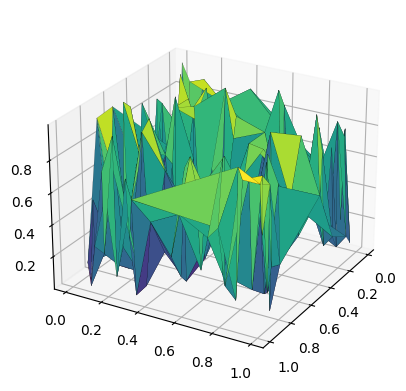

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

generator = tf.keras.models.load_model('gan_model.h5')

random_noise_dim = 100
random_noise = np.random.normal(0, 1, (1, random_noise_dim))

generated_mesh = generator.predict(random_noise)

x = generated_mesh[0][:, 0]
y = generated_mesh[0][:, 1]
z = generated_mesh[0][:, 2]

x = x.flatten()
y = y.flatten()
z = z.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

triangulation = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='k', linewidth=0.1)

triangulation.set_facecolor('b')


ax.view_init(elev=25, azim=30)

plt.show()



1/1 [==============================] - 0s 391ms/step


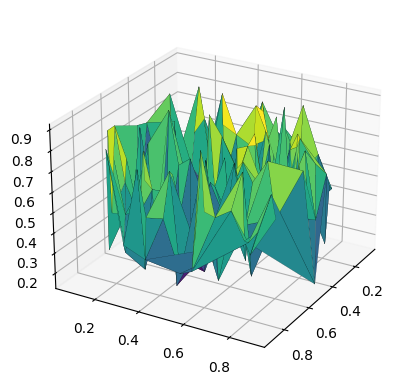

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

generator = tf.keras.models.load_model('gan_model.h5')

random_noise_dim = 100
random_noise = np.random.normal(0, 1, (1, random_noise_dim))

generated_mesh = generator.predict(random_noise)

x = generated_mesh[0][:, 0]
y = generated_mesh[0][:, 1]
z = generated_mesh[0][:, 2]

x = x.flatten()
y = y.flatten()
z = z.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

triangulation = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='k', linewidth=0.1)

triangulation.set_facecolor('b')


ax.view_init(elev=25, azim=30)

plt.show()

1/1 [==============================] - 0s 76ms/step


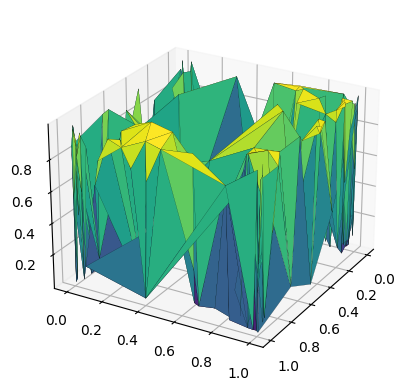

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

generator = tf.keras.models.load_model('gan_model.h5')

random_noise_dim = 100
random_noise = np.random.normal(0, 1, (1, random_noise_dim))

generated_mesh = generator.predict(random_noise)

x = generated_mesh[0][:, 0]
y = generated_mesh[0][:, 1]
z = generated_mesh[0][:, 2]

x = x.flatten()
y = y.flatten()
z = z.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

triangulation = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='k', linewidth=0.1)

triangulation.set_facecolor('b')


ax.view_init(elev=25, azim=30)

plt.show()

32/32 [==============================] - 0s 3ms/step


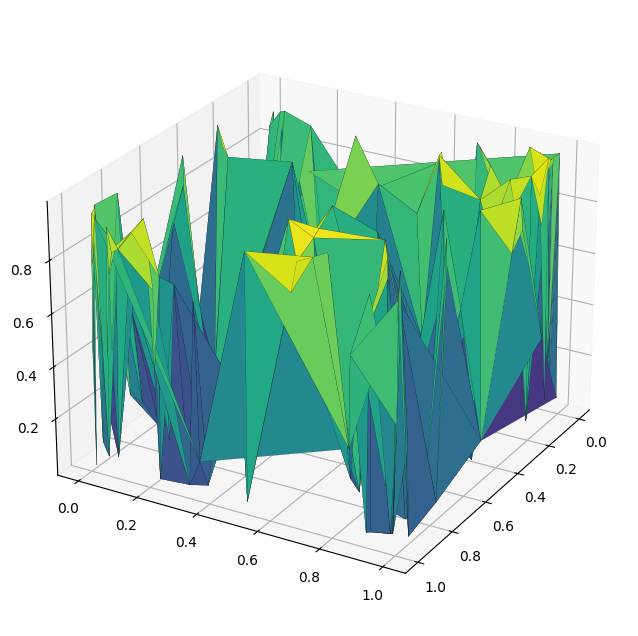

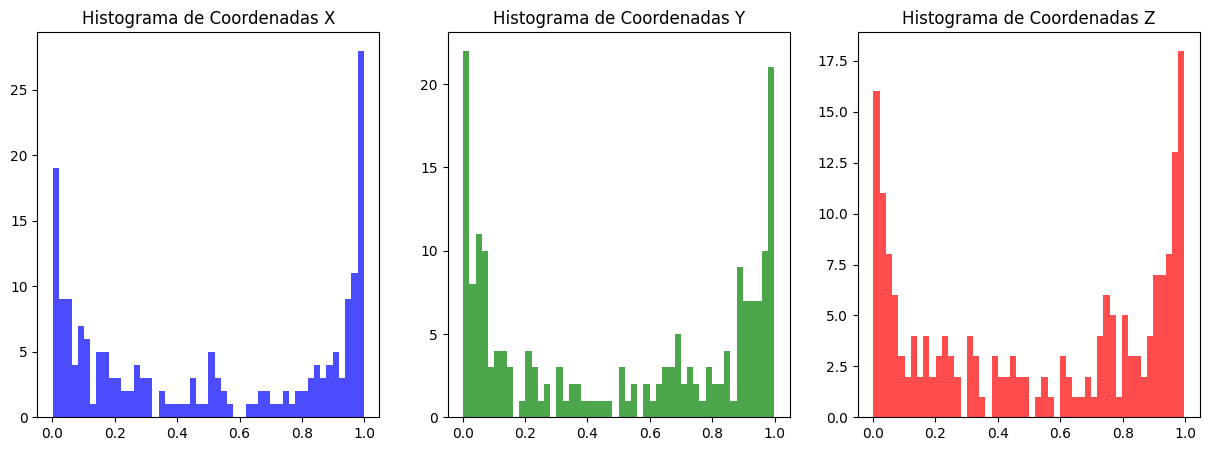


Tabla de Resumen de Estadísticas:
   count      mean       std       min       25%       50%       75%       max
X  192.0  0.504920  0.388621  0.002207  0.100495  0.501831  0.932688  0.997607
Y  192.0  0.511470  0.387752  0.001305  0.077148  0.590953  0.911981  0.998281
Z  192.0  0.526983  0.373810  0.001674  0.137170  0.590237  0.906412  0.996424


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

generator = tf.keras.models.load_model('gan_model.h5')

random_noise_dim = 100
random_noise = np.random.normal(0, 1, (1000, random_noise_dim))  # Generar 1000 puntos

generated_mesh = generator.predict(random_noise)

x = generated_mesh[0][:, 0]
y = generated_mesh[0][:, 1]
z = generated_mesh[0][:, 2]

x = x.flatten()
y = y.flatten()
z = z.flatten()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
triangulation = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='k', linewidth=0.1)
triangulation.set_facecolor('b')
ax.view_init(elev=25, azim=30)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].hist(x, bins=50, color='blue', alpha=0.7)
axes[0].set_title('Histograma de Coordenadas X')

axes[1].hist(y, bins=50, color='green', alpha=0.7)
axes[1].set_title('Histograma de Coordenadas Y')

axes[2].hist(z, bins=50, color='red', alpha=0.7)
axes[2].set_title('Histograma de Coordenadas Z')

plt.show()

df = pd.DataFrame({'X': x, 'Y': y, 'Z': z})
summary_table = df.describe().transpose()
print("\nTabla de Resumen de Estadísticas:")
print(summary_table)

In [9]:
from sklearn.metrics import mean_absolute_error, explained_variance_score

generator = tf.keras.models.load_model('gan_model.h5')

random_noise_dim = 100
random_noise = np.random.normal(0, 1, (1000, random_noise_dim))  

generated_mesh = generator.predict(random_noise)

real_data = np.random.random(generated_mesh.shape)

generated_mesh_flat = generated_mesh.flatten()
real_data_flat = real_data.flatten()

mae = mean_absolute_error(real_data_flat, generated_mesh_flat)
variance_explained = explained_variance_score(real_data_flat, generated_mesh_flat)

print(f"\nError Medio Absoluto: {mae}")
print(f"Varianza Explicada: {variance_explained}")

32/32 [==============================] - 0s 3ms/step

Error Medio Absoluto: 0.3375325155243595
Varianza Explicada: -1.0510462850877769
